# Dataset

In [1]:
import torch
from torchvision import datasets, transforms
import pycocotools
import matplotlib.pyplot as plt
import numpy as np
from datasets import COCOSegmentation

In [ ]:
# OLD
# def annToRLE(im, ann):
#     """
#     Convert annotation which can be polygons, uncompressed RLE to RLE.
#     :return: binary mask (numpy 2D array)
#     """
#     h, w = im.shape[2:]
#     print(h, w)
#     segm = ann['segmentation'][0]
#     print(segm)
#     if type(segm) == list:
#         # polygon -- a single object might consist of multiple parts
#         # we merge all parts into one mask rle code
#         rles = pycocotools.mask.frPyObjects(segm, h, w)
#         rle = pycocotools.mask.merge(rles)
#     elif type(segm['counts']) == list:
#         # uncompressed RLE
#         rle = pycocotools.mask.frPyObjects(segm, h, w)
#     else:
#         # rle
#         rle = ann['segmentation']
#     return rle

# def annToMask(im, ann):
#     """
#     Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
#     :return: binary mask (numpy 2D array)
#     """
#     rle = annToRLE(im, ann)
#     m = pycocotools.mask.decode(rle)
#     return m

In [2]:
dataDir='../Datasets/coco-2017/'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [3]:
dataset = COCOSegmentation(dataDir, 'val', crop_size=0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=None)

val set
loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
Loaded 5000 samples from ../Datasets/coco-2017/annotations/val_ids.pkl


In [ ]:
len(dataset)

In [ ]:
# OLD
dataset = datasets.CocoDetection(root = dataDir + dataType,
                                 annFile = annFile, 
                                 transform = transforms.ToTensor(), 
                                 target_transform = None,
                                 transforms = None)

# dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=None)

In [ ]:
dataset.ids

In [ ]:
import pickle as pkl

In [ ]:
len(pkl.load(open('../Datasets/coco-2017/annotations/val_ids.pkl', 'rb')))

In [ ]:
i, l, n = dataset[0]
i.shape, l.shape, n

In [ ]:
for (i, l, n) in dataloader:
    print(i.shape, l.shape, n)

In [ ]:
# OLD
# for i, l in dataloader:
#     print(i.shape)
#     print(l[0].keys())
#     break

In [ ]:
plt.imshow(i[0])
plt.imshow(l[0], alpha=0.5)
plt.show()
l.unique()

In [ ]:
# OLD

# Get binary mask from annotation
# plt.imshow(i[0].permute(1,2,0))
# m = np.zeros((i.shape[2], i.shape[3]))
# for p in l:
#     m += annToMask(i, p)
# plt.imshow(m, alpha=0.5)
# plt.show()

# Model

In [4]:
import requests

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import torch
from transformers import (SamModel, SamProcessor)

from utils import *

### Load model

In [5]:
torch.manual_seed(0)
np.random.seed(0)

GPU = 3

device = torch.device(f"cuda:{GPU}" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# Sparse SAM
sparse = SamModel.from_pretrained("bin/90/").to(device).eval()

### Get Input Image

In [6]:
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
# plt.imshow(raw_image)
# plt.show()

### Run Inference with Prompt

In [18]:
input_points = [[[450, 600]]]
# show_points_on_image(raw_image, input_points[0])

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])


inputs.pop("pixel_values", None) # pixel_values are no more needed
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

In [19]:
outputs['iou_scores'], outputs['pred_masks'].shape

(tensor([[[0.9910, 0.9818, 0.9667]]], device='cuda:3'),
 torch.Size([1, 1, 3, 256, 256]))

### Decode Output

In [20]:
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), 
                                                     inputs["reshaped_input_sizes"].cpu(), binarize=False)
masks[0].shape

torch.Size([1, 3, 1764, 2646])

tensor(-15.1606) tensor(24.9779)


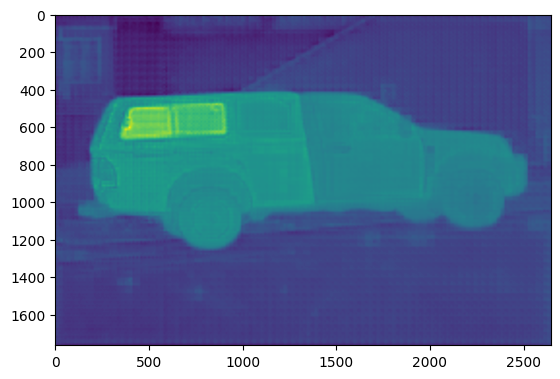

In [21]:
plt.imshow(masks[0][0][2].cpu())
print(masks[0][0][2].cpu().min(), masks[0][0][2].cpu().max())

In [ ]:
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu(), )[0]
scores = outputs.iou_scores
show_masks_on_image(raw_image, masks, scores)

In [ ]:
plt.imshow(masks.squeeze()[scores.argmax()])
plt.show()

# Outputs

In [ ]:
import random
import torch

In [ ]:
CENTER = True

In [ ]:
def get_output_masks(processor, model, i, input_points, device):
    inputs = processor(i, input_points=input_points, return_tensors="pt").to(device)
    image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
    inputs.pop("pixel_values", None) # pixel_values are no more needed
    inputs.update({"image_embeddings": image_embeddings})
    with torch.no_grad():
        outputs = model(**inputs)
    masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0]
    scores = outputs.iou_scores
    return masks, scores
    
def get_prompt(name, label):

    # Load_prompts missing

    C = np.unique(label)[1:]
    c = np.random.choice(C)

    if CENTER:
        x, y = torch.sum(torch.argwhere(label==c),0)/torch.sum(label==c).detach().cpu().numpy() # does not work for multiple instances of same class
        x, y = int(x), int(y)
    else:
        x_v, y_v = np.where(label == c)
        r = random.randint(0,len(x_v))
        x, y = x_v[r], y_v[r]
    return [[[y,x]]], c # inverted to compensate different indexing

In [ ]:
def get_masks():

    name_list, mask_list, score_list, prompt_list, p_class_list = [], [], [], [], []
    for j, (i, l, n) in enumerate(dataloader):

        prompt, p_class = get_prompt(n, l[0])
        # show_points_on_image(i[0], input_points[0])

        masks, scores = get_output_masks(processor, model, i, prompt, device)
        # show_masks_on_image(i[0], masks, scores)  
        
        name_list.append(int(n[0]))
        mask_list.append(masks.squeeze()[scores.argmax()].cpu().detach().numpy())
        score_list.append(float(scores.max().cpu().detach().numpy()))
        prompt_list.append(prompt[0][0])
        p_class_list.append(int(p_class))

        if j > 1:
            break

    return name_list, prompt_list, p_class_list, mask_list, score_list

In [ ]:
name, prompt, p_class, mask, score = get_masks()

In [ ]:
i = 0
name[i], prompt[i], p_class[i], mask[i], score[i]

In [ ]:
plt.imshow(mask[i])
print(dataset.classes[p_class[i]])
print(name[i])
plt.scatter(*prompt[i])
plt.show()

In [ ]:
for i, l, n in dataloader:
    plt.imshow(l[0])
    break

In [ ]:
Image.open('/mnt/Data/sa58728/coco-2017/val2017/' + str(name[i]).zfill(12) + '.jpg')

### Save DataFrame

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({'name': name, 'prompt': prompt, 'class': p_class, 'mask': mask, 'score': score})

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.hist(column='class')

In [ ]:
df[['name', 'point', 'class']].to_pickle("results/coco_prompts.pkl")

In [ ]:
df[['name', 'point', 'class']]

In [ ]:
df = pd.read_pickle("results/cityscapes_prompts.pkl")

In [ ]:
df.head()

In [ ]:
df[df['name']==632][['point', 'class']].values[0][1]

### Predicted Classes

In [ ]:
N_CLASSES = 92

In [ ]:
def get_instance(label, c=None):
    if c is None:
        C = np.unique(label)[1:]
        c = np.random.choice(C)
        return label == c, c
    else:
        return label == c, c

def get_pred_classes(inst, label, n_classes, threshold=0.01):
    im = torch.logical_not(inst).to(torch.uint8)
    im[im==1] = n_classes
    m = im + label
    h, _ = np.histogram(m, bins=256, range=(0,255))
    clean_h = h[:n_classes]
    mask_tot = np.sum(clean_h)
    classes = np.where(clean_h > threshold * mask_tot)[0]
    return list(classes)

### Test class threshold

In [ ]:
# Label
l = torch.zeros((224,224), dtype=torch.uint8)
l[100:150, 50:100] = 35
l[145:150, 95:100] = 91
l[100:140, 160:200] = 60
l[100:115, 50:65] = 0

plt.imshow(l)
plt.show()

In [ ]:
# Predicted instance
i = torch.zeros((224,224), dtype=bool)
i[100:150, 50:100] = True
plt.imshow(i)
plt.show()

In [ ]:
get_pred_classes(i, l, N_CLASSES, 0.01)

In [ ]:
# Modified instance
im = torch.logical_not(i).to(torch.uint8)
im[im==1] = N_CLASSES

plt.imshow(im)
plt.show()

In [ ]:
im.min(), im.max()

In [ ]:
# Mask (intersection)
m = im + l

plt.imshow(m)
plt.show()

In [ ]:
m.unique()

In [ ]:
h, _ = np.histogram(m, bins=256, range=(0,255))
h

In [ ]:
clean_h = h[:N_CLASSES]
clean_h

In [ ]:
mask_tot = np.sum(clean_h)
mask_tot

In [ ]:
np.where(clean_h > 0.01 * mask_tot)

# Metrics

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt

from utils import show_points_and_masks_on_image

%matplotlib inline
%load_ext autoreload

In [ ]:
EXPERIMENT = 'center_'
DATASET = 'coco'
MODEL = 'SAM'
ROOT = Path("../Datasets/coco-2017/val2017/") if DATASET == 'coco' else Path("../Datasets/Cityscapes/leftImg8bit/val/")
SPARSITY = 50
CLASSES = ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
           'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
           'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports', 'kite', 
           'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 
           'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
           'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
           'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
           'hair drier', 'toothbrush', 'hair brush']

In [ ]:
def calculate_metrics(target, pred, eps=1e-5, verbose=False):

    if verbose:
        plt.subplot(1, 2, 1)
        plt.imshow(target)
        plt.subplot(1, 2, 2)
        plt.imshow(pred)
        plt.show()

    output = np.reshape(pred, -1)
    target = np.reshape(target, -1)

    tp = np.sum(output * target)  # TP (Intersection)
    un = np.sum(output + target)  # Union
    fp = np.sum(output * (~target))  # FP
    fn = np.sum((~output) * target)  # FN
    tn = np.sum((~output) * (~target))  # TN

    iou = (tp + eps) / (un + eps)
    pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    specificity = (tn + eps) / (tn + fp + eps)

    if verbose:
        print(f"IoU: {iou:.4f}, Pixel Acc: {pixel_acc:.4f}, Dice: {dice:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}")

    return iou, pixel_acc, dice, precision, specificity, recall

def get_analytics(target_df, pred_df):
    metrics = {k: [] for k in ['name', 'prompt', 'class', 't_class', 's_class', 'score', 'score_diff', 'mask_size', 
                               'mask_size_diff', 'iou', 'pixel_acc', 'dice', 'precision', 'recall', 'specificity']}
    for i in range(len(target_df)):
        target = target_df.loc[i]
        pred = pred_df.loc[i]

        iou, pixel_acc, dice, precision, specificity, recall = calculate_metrics(target['mask'], pred['mask'])
        
        metrics['name'].append(target['name'])
        metrics['prompt'].append(target['prompt'])
        metrics['class'].append(target['class'])
        metrics['t_class'].append(target['s_class'])
        metrics['s_class'].append(pred['s_class'])
        metrics['score'].append(pred['score'])
        metrics['score_diff'].append((pred['score'] - target['score']) / (target['score'] + 1e-5))
        p_size = np.mean(pred['mask'].astype('float'))
        t_size = np.mean(target['mask'].astype('float'))
        metrics['mask_size'].append(p_size)
        metrics['mask_size_diff'].append((p_size - t_size) / (t_size + 1e-3))
        metrics['iou'].append(iou)
        metrics['pixel_acc'].append(pixel_acc)
        metrics['dice'].append(dice)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['specificity'].append(specificity)
    
    return pd.DataFrame(metrics)

def get_labels(name):
    if isinstance(name, list):
        return [get_labels(n) for n in name]
    else: 
        return CLASSES[name].title()

def get_image(name):
    if DATASET == 'coco':
        image_path = ROOT.joinpath(f'{str(name).zfill(12)}.jpg')
    else:
        image_path = ROOT.joinpath(f"{name.split('_')[0]}/{name}")
    return np.array(Image.open(image_path).convert("RGB"))

def show_entry(row, target_df, pred_df):
    image = get_image(row['name'])
    target_mask = target_df[target_df['name']==row['name']]['mask'].values[0]
    pred_mask = pred_df[pred_df['name']==row['name']]['mask'].values[0]
    show_points_and_masks_on_image(image, [pred_mask, target_mask], [row['prompt']])
    print(f'ID: {row["name"]}, PromptClass: {get_labels(row["class"])}, TargetClass: {get_labels(row["t_class"])}, PredClass: {get_labels(row["s_class"])},') 
    print(f'ScoreDiff: {row["score_diff"]:.4f}, MaskSizeDiff: {row["mask_size_diff"]:.4f}, IoU: {row["iou"]:.4f}')
    
def show_samples(pie_df, target_df, pred_df, n=5):
    print('Legend: Target -> Orange, Prediction -> Blue')
    pie_df.iloc[:n].apply(lambda x: show_entry(x, target_df, pred_df), axis=1)

In [ ]:
df_p = pd.read_pickle(f"results/{EXPERIMENT}{DATASET}_prompts.pkl")
df_0 = pd.read_pickle(f"results/{EXPERIMENT}{DATASET}_{MODEL}_0.pkl")
df_s = pd.read_pickle(f"results/{EXPERIMENT}{DATASET}_{MODEL}_{SPARSITY}.pkl")
df_0.head()

In [ ]:
df_0s = get_analytics(df_0, df_s)
df_0s.head()

In [ ]:
plt.hist(df_0s['mask_size_diff'], range=(-15,80))
plt.semilogy()
plt.show()

In [ ]:
min_size = df_0s.nsmallest(25, ['mask_size_diff'])
max_size = df_0s.nlargest(25, ['mask_size_diff'])
min_score = df_0s.nsmallest(25, ['score_diff']) # not very useful
max_score = df_0s.nlargest(25, ['score_diff']) # not very useful
min_iou = df_0s.nsmallest(25, ['iou'])
max_iou = df_0s.nlargest(25, ['iou'])
min_size.head()

In [ ]:
max_iou.head()

In [ ]:
show_samples(min_size, df_0, df_s, 5)

# Test